# Introduction

In this section, we will:
1. Mount the Google Drive and read the CSV
2. Train a vanilla LSTM model using Open
3. Train another vanilla LSTM model using FilteredOpen
4. Plot and compare our model results

As mentioned at the end of Part I, we will be answering two questions:
1. Can LSTM help with stock predictions?
2. Can using signal processing technique help with improving stock predictions?

In [1]:
# Import pandas as pd

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM
from keras.layers import Dropout 
import pandas as pd

### Split your data into train and test
We split our DataFrame into train and test DataFrames according to the following dates:

- Train data: January 3 2000 to May 16 2019
- Test data: May 15 2019 to July 1 2019

In [3]:
# Split DataFrame into train and test
df = pd.read_csv('df_iii.csv')
split_date ='2008-04-12'
df_train = df.loc[(df['Date'] >= "2000-01-03") & (df["Date"] <= "2019-05-16")]
df_train = df_train.set_index("Date")
df_train.index = pd.to_datetime(df_train.index)

df_test = df.loc[(df['Date'] >= "2019-05-15") & (df["Date"] <= "2019-07-01")]
df_test = df_test.set_index("Date")
df_test.index = pd.to_datetime(df_test.index)

# Data Preparation

We'll prepare three separate sets of scaled training data:
1. Open
2. FilteredOpen
3. ZeroMeanFilteredOpen (we'll get to that soon)

In [4]:
# Get the mean of 'FilteredOpen' from train
filteredOpenMean = df_train.FilteredOpen.mean()

# Create 'ZeroMeanFilteredOpen' in train
df_train["ZeroMeanFilteredOpen"] = df_train["FilteredOpen"] - filteredOpenMean

# Create 'ZeroMeanFilteredOpen' in test
df_test["ZeroMeanFilteredOpen"] = df_test["FilteredOpen"] - filteredOpenMean

In [5]:
# Declare a StandardScaler for Open
openScaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance

# Call .fit_transform on the 'Open' column values from train dataset
openScaler.fit_transform(np.array(df_train.Open).reshape(-1,1))

# Declare a StandardScaler for FilteredOpen
filteredOpenScaler = StandardScaler()

# Call .fit_transform on the 'FilteredOpen' column values from train dataset
filteredOpenScaler.fit_transform(np.array(df_train.FilteredOpen).reshape(-1,1))

# Declare a StandardScaler for ZeroMeanFilteredOpen
zeroMeanFilteredOpenScaler = StandardScaler()

# Call .fit_transform on the 'ZeroMeanFilteredOpen' column values from train dataset
zeroMeanFilteredOpenScaler.fit_transform(np.array(df_train.ZeroMeanFilteredOpen).reshape(-1,1))

array([[-0.03568282],
       [-0.12813507],
       [-0.1688115 ],
       ...,
       [ 2.4588267 ],
       [ 2.45085386],
       [ 2.44992725]])

### Prepare create arrays for training

![LSTMTrainingWindow](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/LSTMTrainingWindow.png)


![OpenXyTrainList](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/OpenXyTrainList.png)


In [6]:
# Prepare X train and y train using scaled "Open"
open_X_train, open_Y_train = [], []
open_values = openScaler.fit_transform(np.array(df_train.Open).reshape(-1,1))
for i in range(len(open_values)-2):
    open_X_train.append(open_values[i:i+2].reshape(1,-1)[0])
    open_Y_train.append(open_values[i+2][0])

# Prepare X train and y train using scaled "FilteredOpen"
filtered_open_X_train, filtered_open_Y_train = [], []
filtered_open_values = filteredOpenScaler.fit_transform(np.array(df_train.FilteredOpen).reshape(-1,1))
for i in range(len(filtered_open_values)-2):
    filtered_open_X_train.append(filtered_open_values[i:i+2].reshape(1,-1)[0])
    filtered_open_Y_train.append(filtered_open_values[i+2][0])

# Prepare X train and y train using scaled "ZeroMeanFilteredOpen"
zero_mean_filtered_open_X_train, zero_mean_filtered_open_Y_train = [], []
zero_mean_filtered_open_values = zeroMeanFilteredOpenScaler.fit_transform(np.array(df_train.ZeroMeanFilteredOpen).reshape(-1,1))
for i in range(len(zero_mean_filtered_open_values)-2):
    zero_mean_filtered_open_X_train.append(zero_mean_filtered_open_values[i:i+2].reshape(1,-1)[0])
    zero_mean_filtered_open_Y_train.append(zero_mean_filtered_open_values[i+2][0])

### Turn the X train and y train lists into NumPy arrays

In [7]:
# Turn open X train list into NumPy array
open_X_train = np.asarray(open_X_train)

# Turn open y train list into NumPy array
open_Y_train = np.asarray(open_Y_train)

# Turn filtered X train list into NumPy array
filtered_open_X_train = np.asarray(filtered_open_X_train)

# Turn filtered y train list into NumPy array
filtered_open_Y_train = np.asarray(filtered_open_Y_train)

# Turn open X train list into NumPy array
zero_mean_filtered_open_X_train = np.asarray(zero_mean_filtered_open_X_train)

# Turn open y train list into NumPy array)
zero_mean_filtered_open_Y_train = np.asarray(zero_mean_filtered_open_Y_train)

In [8]:
print(open_X_train.shape)
print(open_Y_train.shape)

(4871, 2)
(4871,)


### Reshape X train NumPy arrays
We will now reshape our X train arrays from 2D to 3D.

In [9]:
# Reshape your "Open" X train array
open_X_train = open_X_train[..., np.newaxis]

# Reshape your "FilteredOpen" X train array
filtered_open_X_train = filtered_open_X_train[..., np.newaxis]

# Reshape your "ZeroMeanFilteredOpen" X train array
zero_mean_filtered_open_X_train = zero_mean_filtered_open_X_train[..., np.newaxis]

### Set up the model architecture
We'll do the following steps to set up a model.

1. Declare a variable, and store a Sequential object
2. [First layer] Add a LSTM layer
  *   50 units
  *   return sequences
  *   input shape as a tuple with (2, 1)
3. [Second layer] Add a Dropout layer, with a rate of 0.3
4. [Third layer] Add an LSTM layer
  *   50 units
5. [Fourth layer] Add a Dropout layer, with a rate of 0.3
6. [Fifth layer] Add a Dense layer
  *   1 units

In [10]:
# Set up your model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(2,1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50))
model.add(Dropout(0.3))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 2, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile and fit your data
model.compile(optimizer="adam", loss = "mse")
model.fit(open_X_train, open_Y_train, epochs = 15, batch_size = 32)

Epoch 1/15
153/153 [==============================] - 3s 3ms/step - loss: 0.2059
Epoch 2/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 3/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 4/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 5/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 6/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 7/15
153/153 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 8/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 9/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 10/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 11/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 12/15
153/153 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 13/15
153/153 [====

In [12]:
# Transform, loop, transform, and reshape "Open" test X data
open_X_test, open_Y_test = [], []
open_test_values = openScaler.fit_transform(np.array(df_test.Open).reshape(-1,1))

for i in range(len(open_test_values)-2):
    open_X_test.append(open_test_values[i:i+2].reshape(1,-1)[0])
    open_Y_test.append(open_test_values[i+2][0])
    
open_X_test = np.asarray(open_X_test)
open_Y_test = np.asarray(open_Y_test)

open_X_test = open_X_test[..., np.newaxis]

## Make predictions

In [13]:
prediction_open_test = openScaler.inverse_transform(model.predict(open_X_test))
prediction_open_test

1/1 [==============================] - 1s 717ms/step


array([[2830.5466],
       [2855.6057],
       [2852.7998],
       [2844.6953],
       [2853.6348],
       [2849.5486],
       [2834.9683],
       [2831.3706],
       [2818.831 ],
       [2791.3054],
       [2783.5613],
       [2766.249 ],
       [2759.914 ],
       [2782.0925],
       [2821.2512],
       [2835.1948],
       [2861.5452],
       [2890.0579],
       [2896.439 ],
       [2882.7112],
       [2885.3936],
       [2886.685 ],
       [2893.9163],
       [2910.4075],
       [2929.5269],
       [2951.4773],
       [2953.3098],
       [2950.6426],
       [2940.5054],
       [2924.1992],
       [2923.6533]], dtype=float32)

In [14]:
# Create a DataFrame for "Open" prediction
df_open_prediction = pd.DataFrame({"Date":df_test.index[2:]})
df_open_prediction["Open Prediction"] = prediction_open_test
df_open_prediction["S&P 500 Stock Price"] = list(df_test.Open)[2:]
df_open_prediction = df_open_prediction.set_index("Date")

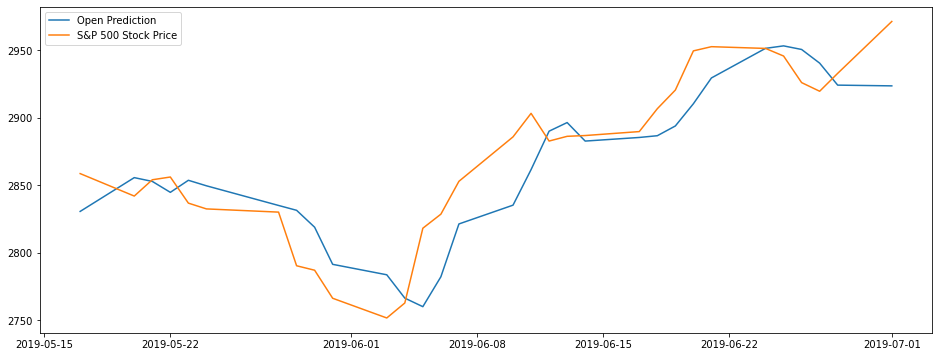

In [15]:
# Plot "Open" prediction with the original test "Open"

plt.figure(figsize=(16, 6))
plt.plot(df_open_prediction)
plt.legend(df_open_prediction)

### Repeat for "FilteredOpen" and "ZeroMeanFilteredOpen" 
Now that we've successfully done predictions using data from "Open", let's work on "FilteredOpen" and "ZeroMeanFilteredOpen" next.

In [16]:
# Set up model architecture for FilteredOpen, compile, and fit "FilteredOpen" data
model_filtered_open = Sequential()
model_filtered_open.add(LSTM(50, input_shape=(2,1), return_sequences=True))
model_filtered_open.add(Dropout(0.3))
model_filtered_open.add(LSTM(50))
model_filtered_open.add(Dropout(0.3))
model_filtered_open.add(Dense(1))
model_filtered_open.summary()
model_filtered_open.compile(optimizer="adam", loss = "mse")
model_filtered_open.fit(filtered_open_X_train, filtered_open_Y_train, epochs = 15, batch_size = 32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 50)             10400     
                                                                 
 dropout_2 (Dropout)         (None, 2, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
153/153 [==============================

In [17]:
# Transform, loop, transform, and reshape "FilteredOpen" test X data (Step 13)
filtered_open_X_test, filtered_open_Y_test = [], []
filtered_open_test_values = filteredOpenScaler.fit_transform(np.array(df_test.FilteredOpen).reshape(-1,1))

for i in range(len(filtered_open_test_values)-2):
    filtered_open_X_test.append(filtered_open_test_values[i:i+2].reshape(1,-1)[0])
    filtered_open_Y_test.append(filtered_open_test_values[i+2][0])
    
filtered_open_X_test = np.asarray(filtered_open_X_test)
filtered_open_Y_test = np.asarray(filtered_open_Y_test)

filtered_open_X_test = filtered_open_X_test[..., np.newaxis]

# Make the predict method and inverse_transform call (Step 14)
prediction_filtered_open_test = filteredOpenScaler.inverse_transform(model_filtered_open.predict(filtered_open_X_test))
prediction_filtered_open_test

# Create a DataFrame for your "FilteredOpen" prediction (Step 15)
df_filtered_open_prediction = pd.DataFrame({"Date":df_test.index[2:]})
df_filtered_open_prediction["FilteredOpen Prediction"] = prediction_filtered_open_test
df_filtered_open_prediction = df_filtered_open_prediction.set_index("Date")

1/1 [==============================] - 1s 620ms/step


In [18]:
# Set up your model architecture for ZeroMeanFilteredOpen, compile, and fit "ZeroMeanFilteredOpen" data (Steps 11-12)
model_zero_mean_filtered_open = Sequential()
model_zero_mean_filtered_open.add(LSTM(50, input_shape=(2,1), return_sequences=True))
model_zero_mean_filtered_open.add(Dropout(0.3))
model_zero_mean_filtered_open.add(LSTM(50))
model_zero_mean_filtered_open.add(Dropout(0.3))
model_zero_mean_filtered_open.add(Dense(1))
model_zero_mean_filtered_open.summary()
model_zero_mean_filtered_open.compile(optimizer="adam", loss = "mse")
model_zero_mean_filtered_open.fit(zero_mean_filtered_open_X_train, zero_mean_filtered_open_Y_train, epochs = 15, batch_size = 32)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2, 50)             10400     
                                                                 
 dropout_4 (Dropout)         (None, 2, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
153/153 [==============================

In [19]:
# Transform, loop, transform, and reshape "ZeroMeanFilteredOpen" test X data
zero_mean_filtered_open_X_test, zero_mean_filtered_open_Y_test = [], []
zero_mean_filtered_open_test_values = zeroMeanFilteredOpenScaler.fit_transform(np.array(df_test.ZeroMeanFilteredOpen).reshape(-1,1))
for i in range(len(zero_mean_filtered_open_test_values)-2):
    zero_mean_filtered_open_X_test.append(zero_mean_filtered_open_test_values[i:i+2].reshape(1,-1)[0])
    zero_mean_filtered_open_Y_test.append(zero_mean_filtered_open_test_values[i+2][0])
zero_mean_filtered_open_X_test = np.asarray(zero_mean_filtered_open_X_test)
zero_mean_filtered_open_Y_test = np.asarray(zero_mean_filtered_open_Y_test)
zero_mean_filtered_open_X_test = zero_mean_filtered_open_X_test[..., np.newaxis]

# Make the predict method and inverse_transform call
prediction_zero_mean_filtered_open_test = zeroMeanFilteredOpenScaler.inverse_transform(model_zero_mean_filtered_open.predict(zero_mean_filtered_open_X_test))
prediction_zero_mean_filtered_open_test

# Create a DataFrame for your "ZeroMeanFilteredOpen" prediction
df_zero_mean_filtered_open_prediction = pd.DataFrame({"Date":df_test.index[2:]})
df_zero_mean_filtered_open_prediction["ZeroMeanFilteredOpen Prediction"] = prediction_zero_mean_filtered_open_test
df_zero_mean_filtered_open_prediction["ZeroMeanFilteredOpen Prediction"] = df_zero_mean_filtered_open_prediction["ZeroMeanFilteredOpen Prediction"] + filteredOpenMean
df_zero_mean_filtered_open_prediction = df_zero_mean_filtered_open_prediction.set_index("Date")
# Add the FilteredOpen mean from train DataFrame into all values (reverse the normalization)
df_zero_mean_filtered_open_prediction

1/1 [==============================] - 1s 602ms/step


,ZeroMeanFilteredOpen Prediction
Date,
2019-05-17,2839.837646
2019-05-20,2839.426758
2019-05-21,2839.015137
2019-05-22,2837.200195
2019-05-23,2832.546143
2019-05-24,2826.446533
2019-05-28,2819.870117
2019-05-29,2810.609863
2019-05-30,2798.191162


### Plot all three predictions with the original test "Open"
Which predictions did the best? Let's find out by plotting all three sets of predictions on the same plot. 


In [20]:
df_all_predictions = pd.concat([df_open_prediction, df_filtered_open_prediction, df_zero_mean_filtered_open_prediction], axis = 1)
df_all_predictions.head()

,Open Prediction,S&P 500 Stock Price,FilteredOpen Prediction,ZeroMeanFilteredOpen Prediction
Date,,,,
2019-05-17,2830.546631,2858.600098,2840.340332,2839.837646
2019-05-20,2855.605713,2841.939941,2839.943359,2839.426758
2019-05-21,2852.799805,2854.020020,2839.538330,2839.015137
2019-05-22,2844.695312,2856.060059,2837.755371,2837.200195
2019-05-23,2853.634766,2836.699951,2833.240234,2832.546143


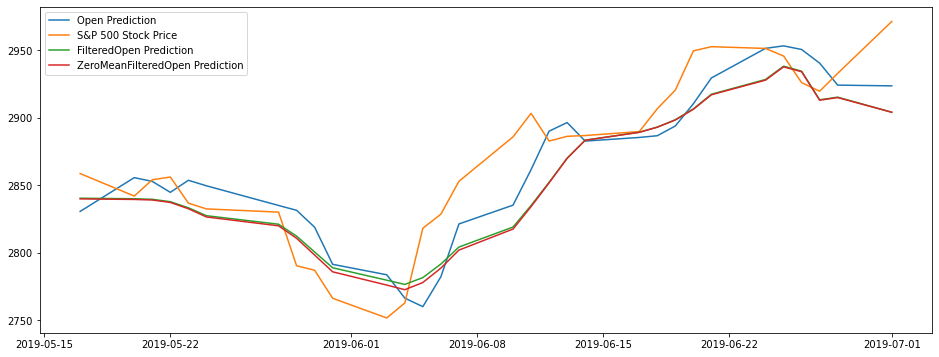

In [21]:
plt.figure(figsize=(16, 6))
plt.plot(df_all_predictions)
plt.legend(df_all_predictions)

### Calculate the RMSE of the three predictions
Visually, we know which predictions performed best.

We calculate the RMSE of the predictions.

In [22]:
# Print the RMSE of test 'Open' and 'Open' predictions
print(mean_squared_error(df_all_predictions["Open Prediction"], df_all_predictions["S&P 500 Stock Price"]) ** 0.5)

# Print the RMSE of test 'Open' and 'FilteredOpen' predictions
print(mean_squared_error(df_all_predictions["FilteredOpen Prediction"], df_all_predictions["S&P 500 Stock Price"]) ** 0.5)

# Print the RMSE of test 'Open' and 'ZeroMeanFilteredOpen' predictions
print(mean_squared_error(df_all_predictions["ZeroMeanFilteredOpen Prediction"], df_all_predictions["S&P 500 Stock Price"]) ** 0.5)

27.68622886872039
29.999993314921753
30.395239217785925


# The end

To recap, we have:
1. Read research on stock pricing and retrieved the data
2. Investigated the ARIMA terms and performed ARIMA modelling
3. Used signal processing techniques to denoise stock data
4. Trained an LSTM model to predict stock pricing data

More things to try:
- More datasets, e.g., HSI and DJI
- More modelling, e.g., more complex LSTM infrastructures